In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import random

In [2]:
#Ler a
df = pd.read_csv('data/enem19-1perc.csv')
df_selecao = pd.read_csv('data/selecao.csv')

# Algumas análises preliminares

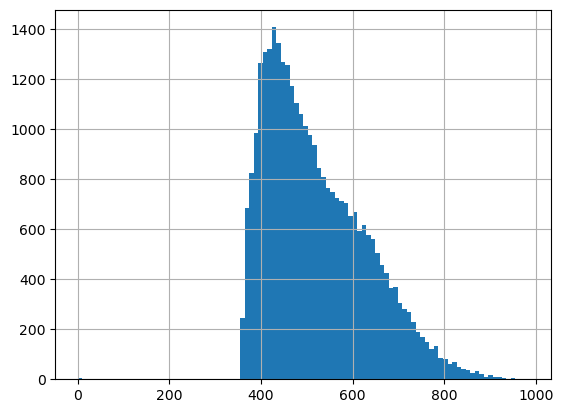

In [14]:
mt = df['NU_NOTA_MT']
ax = mt.hist(bins=100)



In [5]:
df['TP_SEXO'].value_counts()

F    18638
M    13020
Name: TP_SEXO, dtype: int64

In [6]:
df['TP_COR_RACA'].value_counts()

3    14796
1    11066
2     4213
4      791
0      596
5      196
Name: TP_COR_RACA, dtype: int64

In [8]:
df["NU_NOTA_MT"].describe()

count    31658.000000
mean       520.918185
std        110.046439
min          0.000000
25%        432.300000
50%        497.700000
75%        594.600000
max        984.200000
Name: NU_NOTA_MT, dtype: float64

In [12]:
df.query("TP_SEXO == 'F'")["NU_NOTA_MT"].describe()

count    18638.000000
mean       503.156868
std        100.835328
min          0.000000
25%        424.500000
50%        479.400000
75%        564.600000
max        975.200000
Name: NU_NOTA_MT, dtype: float64

In [4]:
acertos = pd.read_csv('data/ac_1_2022_MT.csv')
acertos.sort_values('nota_inep',ascending=False)

,30053,85228,86466,43182,47309,53461,85013,117973,10500,63646,...,82581,31516,68369,60441,117886,95676,19807,acertos,caderno,nota_inep
2075,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,40,1077,972.0
6508,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,40,1078,972.0
1807,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,40,1077,968.6
3105,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,41,1077,968.0
4637,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,41,1077,965.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13940,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,1076,337.5
9116,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,4,1078,337.4
15297,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,1075,337.0
2604,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1077,336.9


<AxesSubplot:xlabel='acertos', ylabel='nota_inep'>

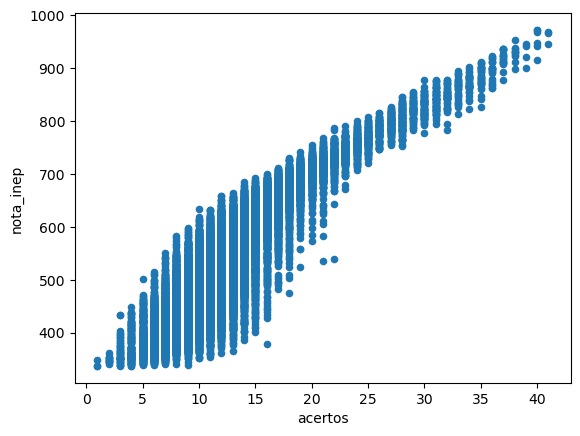

In [5]:
acertos.plot(x='acertos',y='nota_inep',kind='scatter')

In [7]:
acertos['acertos'].describe()

count    18720.000000
mean        13.043910
std          5.535784
min          1.000000
25%          9.000000
50%         12.000000
75%         15.000000
max         41.000000
Name: acertos, dtype: float64